# Stock Selection

There are an enourmous amount of stocks out there and there is relationship between these stocks, in order to make a better prediction of a certain stock based on other stocks, the idea is that dependent stocks which has correlation will produce better prediction.

In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from qml.dataset import download_yfinance
from datetime import datetime, timezone

Defining all the stocks that we consider and other parameters.

In [2]:
TICKERS = [
    "AAPL", # Apple
    "^SPX", # Standard & Poor 500 Index
    "^NDX", # Nasdaq Index
    "YM=F", # Dow Jones Index
    "RTY=F",# Russell 2000 Index
    "^FTSE",# Financial Times Stock Exchange 100 Index
    "AMZN", # Amazon
    "META", # Meta
    "GOOG", # Google
    "TSLA", # Tesla
    "NFLX", # Netflix
    "NVDA", # Nvidia
    "TSM",  # TSMC
    "INTC", # Intel
    "AMD",  # AMD
    "NET",  # Cloudflare
    "GC=F", # Gold
    "SI=F", # Silver
    "CL=F", # Crude Oil
    "COST", # Costco
    "SQ",   # Square
    "F",    # Ford Motor
    "WBD",  # Warner Bros
]
TARGET = "AAPL" # stock that will be predicted
THRESHOLD = 0.8 # correlation >= 0.8 (selection criteria)

Download the historical data (prices) for these stocks.

In [3]:
tickers = download_yfinance(
    tickers=TICKERS, 
    start=datetime(year=2014, month=1, day=1, tzinfo=timezone.utc), 
    end=datetime(year=2024, month=1, day=1, tzinfo=timezone.utc), 
    interval="1d", 
    dir="../../datasets",
)

# Drop unused columns and rename the 'close' column to the ticker name
dfs = [
    df.drop(["open", "high", "low", "volume"]).rename({"close": ticker})
    for df, ticker in zip(tickers, TICKERS)
]

### Helper functions

In [4]:
def filter_join(dfs: list[pl.DataFrame], start: datetime, end: datetime) -> pl.DataFrame:
    """
    Filter out ticker that is not in within the start and end date and join the remaining
    as one dataframe.
    """
    # Take only dataframes that has data within the start and end datetime
    _dfs = [
        df.filter(
            pl
            .col("timestamp")
            .dt
            .cast_time_unit("us")
            .dt
            .replace_time_zone("UTC")
            .is_between(start, end)
        ) for df in dfs
    ]
    dfs = []
    for df in _dfs:
        # do not want empty
        if df.select(pl.len()).item() == 0:
            continue

        # do not want where the first date is a month away from the start date
        if df["timestamp"].dt.year()[0] != start.year and df["timestamp"].dt.month()[0] != start.month:
            continue

        dfs.append(df.with_columns(timestamp=pl.col("timestamp").cast(pl.Date)))

    # Join all the tickers to form one single dataframe
    data = dfs[0]
    for i in range(1, len(dfs)):
        data = data.join(dfs[i], on="timestamp")

    return data


def get_corr(data: pl.DataFrame) -> pl.DataFrame:
    """
    Calculate correlation for each possible permutation of tickers
    """
    return (
        data
        .select([pl.corr(pl.all(), pl.col(c)).name.suffix("|" + c) for c in data.columns]) # Calculate correlation for each possible pairing
        .melt()                                                                          
        .filter(pl.Expr.not_(pl.col("variable").str.contains("timestamp")))      # Drop results that includes the 'timestamp' column
        .with_columns(
            ticker_x=pl.col("variable").str.split("|").list.get(0),              # Add a column 'ticker_x' indicating the x ticker
            ticker_y=pl.col("variable").str.split("|").list.get(1),              # Add a column 'ticker_y' indicating the y ticker
        )
        .drop("variable")                                                        # Drop the 'variable' column (since we have ticker_x and ticker_y)
        .rename({ "value": "correlation" })                                      # Rename 'value' to 'correlation'
        .sort(by=[pl.col("ticker_x"), pl.col("ticker_y")])                       # Sort by the tickers
        .select([pl.col("ticker_x"), pl.col("ticker_y"), pl.col("correlation")]) # Reorder the sequence by selecting it
    )


def plot_corr_matrix(corr_df: pl.DataFrame) -> None:
    """
    Plot the correlation matrix given a result from `get_corr`.
    """
    length: int = corr_df.select("ticker_x").unique().count().item()
    # Construct a 2D array of the correlation values
    corr = np.zeros((length, length))
    rowi = 0
    for i in range(corr_df['correlation'].count()):
        count = corr_df['ticker_x'].unique().count()
        if i > 0 and i % count == 0:
            rowi += 1
        corr[rowi][i % count] = corr_df['correlation'][i]

    fig, ax = plt.subplots(figsize=(length - 2, length - 2))
    ax.imshow(corr) # Plot the correlation values

    # Label the x and y axis
    ax.set_xticks(np.arange(corr_df["ticker_x"].unique().count()), labels=corr_df["ticker_x"].unique().sort())
    ax.set_yticks(np.arange(corr_df["ticker_y"].unique().count()), labels=corr_df["ticker_y"].unique().sort())

    # Label the grid with value
    for i in range(corr_df["ticker_x"].unique().count()):
        for j in range(corr_df["ticker_y"].unique().count()):
            ax.text(j, i, np.round(corr[i, j], 2), ha="center", va="center", color="w")

    plt.title("Correlation Matrix (Ticker Closing Price)")
    plt.show()

Not all stock are launched at the same time, some stock may have missing historical prices. For example, **AAPL** went public in 1980 whereas **META** went public in 2012 so there won't be any **META** historical prices between 1980 - 2011. Hence, to avoid evaluating stocks with no prices one solution is to compare these stocks across different time periods and exclude stock that does not have prices in those periods.

In [5]:
# 5 years from 2014 - 2019
df1 = filter_join(dfs, start=datetime(2014, 1, 1, tzinfo=timezone.utc), end=datetime(2019, 1, 1, tzinfo=timezone.utc))

In [6]:
df1.head()

timestamp,AAPL,^SPX,^NDX,YM=F,^FTSE,AMZN,META,GOOG,TSLA,NFLX,NVDA,TSM,INTC,AMD,GC=F,SI=F,CL=F,COST,F,WBD
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2014-01-02,17.296661,1831.97998,3563.570068,16388.0,6717.899902,19.8985,54.652012,27.724083,10.006667,51.831429,3.740548,12.8689,19.378849,3.95,1225.0,20.098,95.440002,94.780975,9.293518,45.52887
2014-01-03,16.916721,1831.369995,3538.72998,16407.0,6730.700195,19.822001,54.502174,27.521841,9.970667,51.871429,3.695736,12.718826,19.37134,4.0,1238.400024,20.181999,93.959999,94.362617,9.335651,45.263157
2014-01-06,17.008972,1826.77002,3526.959961,16365.0,6730.700195,19.681499,57.139374,27.828691,9.8,51.367142,3.745265,12.681308,19.130888,4.13,1237.800049,20.077,93.43,93.646591,9.377787,44.695965
2014-01-07,16.887327,1837.880005,3557.850098,16454.0,6755.5,19.901501,57.858608,28.365179,9.957333,48.5,3.806584,12.688809,19.228569,4.18,1229.400024,19.764999,93.669998,93.212166,9.257404,44.42514
2014-01-08,16.994274,1837.48999,3567.540039,16407.0,6721.799805,20.096001,58.168282,28.42421,10.085333,48.712856,3.858471,12.823879,19.108349,4.18,1225.300049,19.518,92.330002,91.755966,9.353711,43.234543


In [7]:
corr1 = get_corr(df1)
corr1.head()

ticker_x,ticker_y,correlation
str,str,f64
"""AAPL""","""AAPL""",1.0
"""AAPL""","""AMD""",0.857053
"""AAPL""","""AMZN""",0.920161
"""AAPL""","""CL=F""",-0.170184
"""AAPL""","""COST""",0.92905


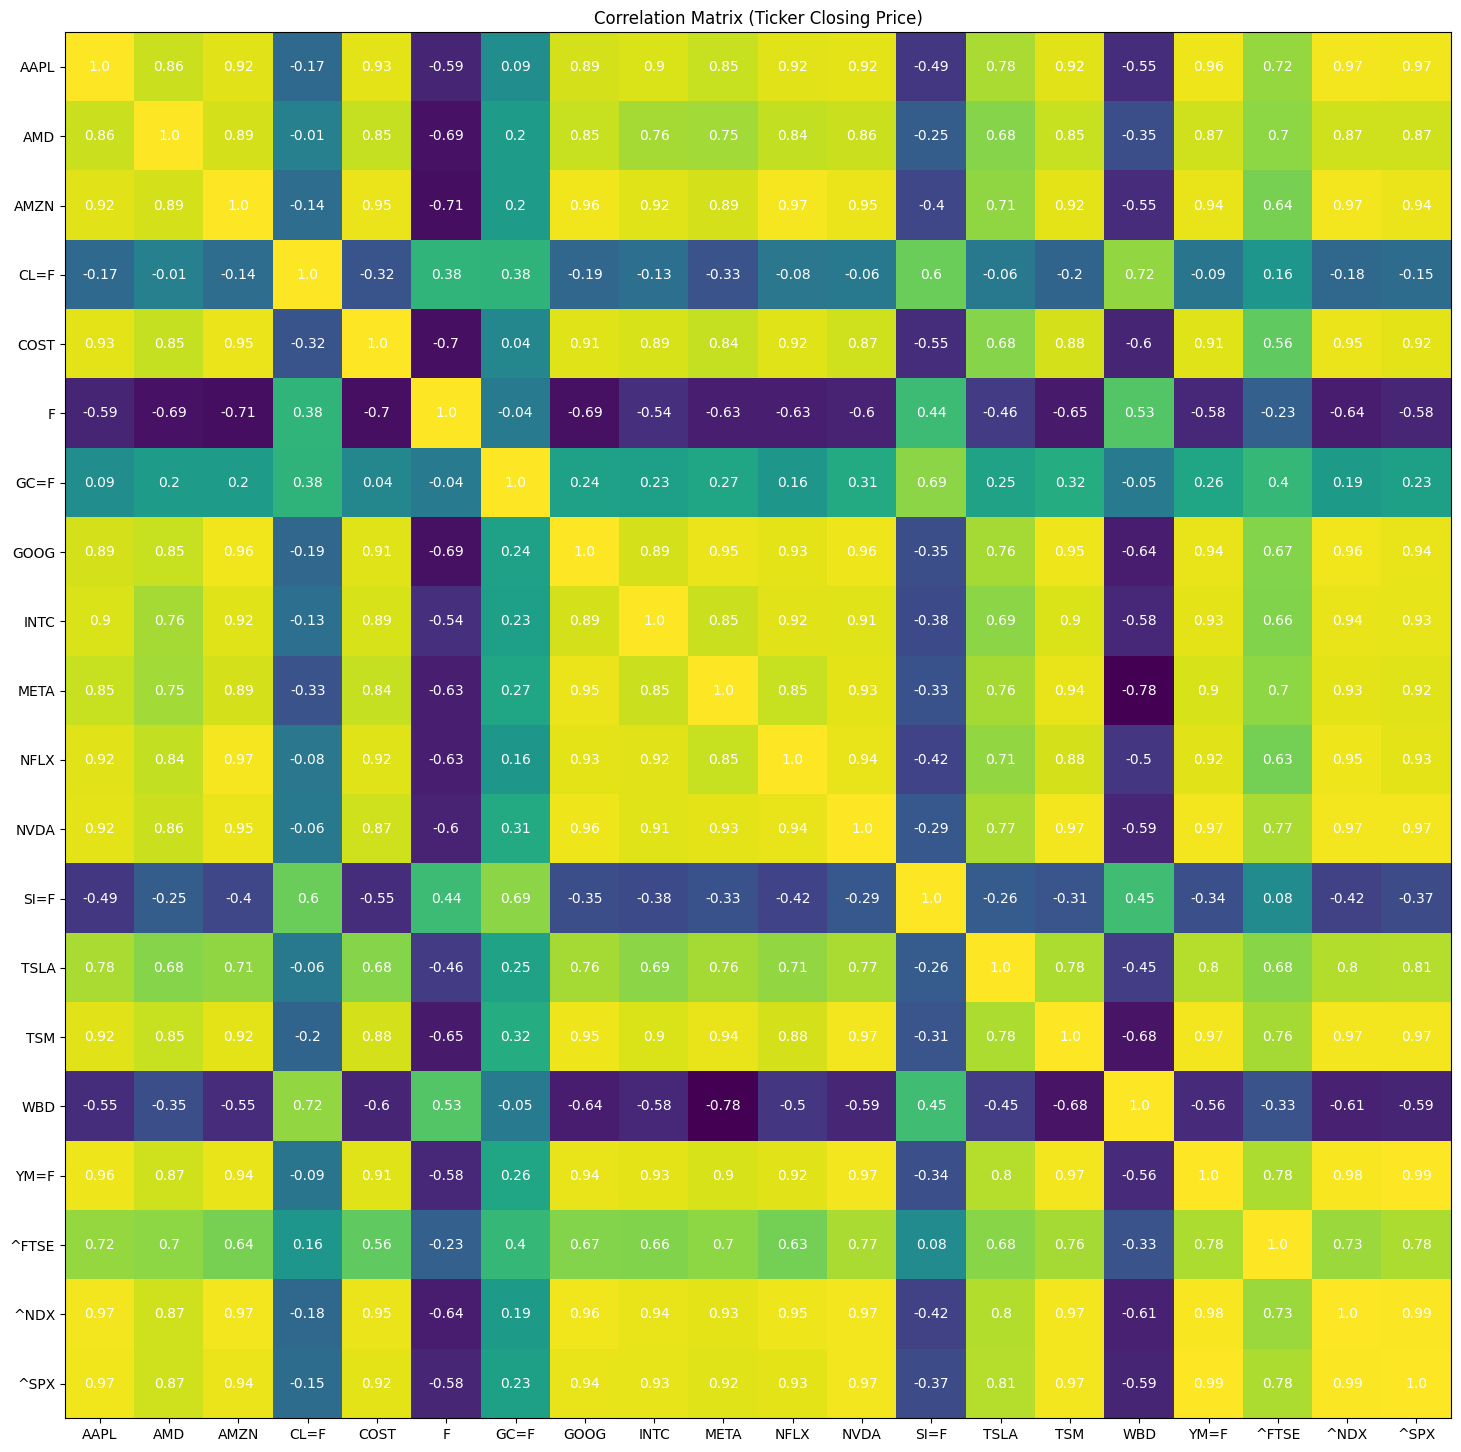

In [8]:
plot_corr_matrix(corr1)

From the correlation matrix plot above we can see the correlation between every stock but since we only care about the target, the query below filters out the pairing that meet our criteria.

In [9]:
filtered1 = corr1.filter(
    pl.Expr.and_(
        pl.col("ticker_x").eq(TARGET), 
        pl.col("correlation").ge(THRESHOLD)
    )
)
filtered1

ticker_x,ticker_y,correlation
str,str,f64
"""AAPL""","""AAPL""",1.0
"""AAPL""","""AMD""",0.857053
"""AAPL""","""AMZN""",0.920161
"""AAPL""","""COST""",0.92905
"""AAPL""","""GOOG""",0.888573
"""AAPL""","""INTC""",0.900695
"""AAPL""","""META""",0.84868
"""AAPL""","""NFLX""",0.919327
"""AAPL""","""NVDA""",0.923664


In [10]:
# 5 years from 2019 - 2024
df2 = filter_join(dfs, start=datetime(2019, 1, 1, tzinfo=timezone.utc), end=datetime(2024, 1, 1, tzinfo=timezone.utc))

In [11]:
corr2 = get_corr(df2)
corr2.head()

ticker_x,ticker_y,correlation
str,str,f64
"""AAPL""","""AAPL""",1.0
"""AAPL""","""AMD""",0.854756
"""AAPL""","""AMZN""",0.37248
"""AAPL""","""CL=F""",0.683949
"""AAPL""","""COST""",0.933928


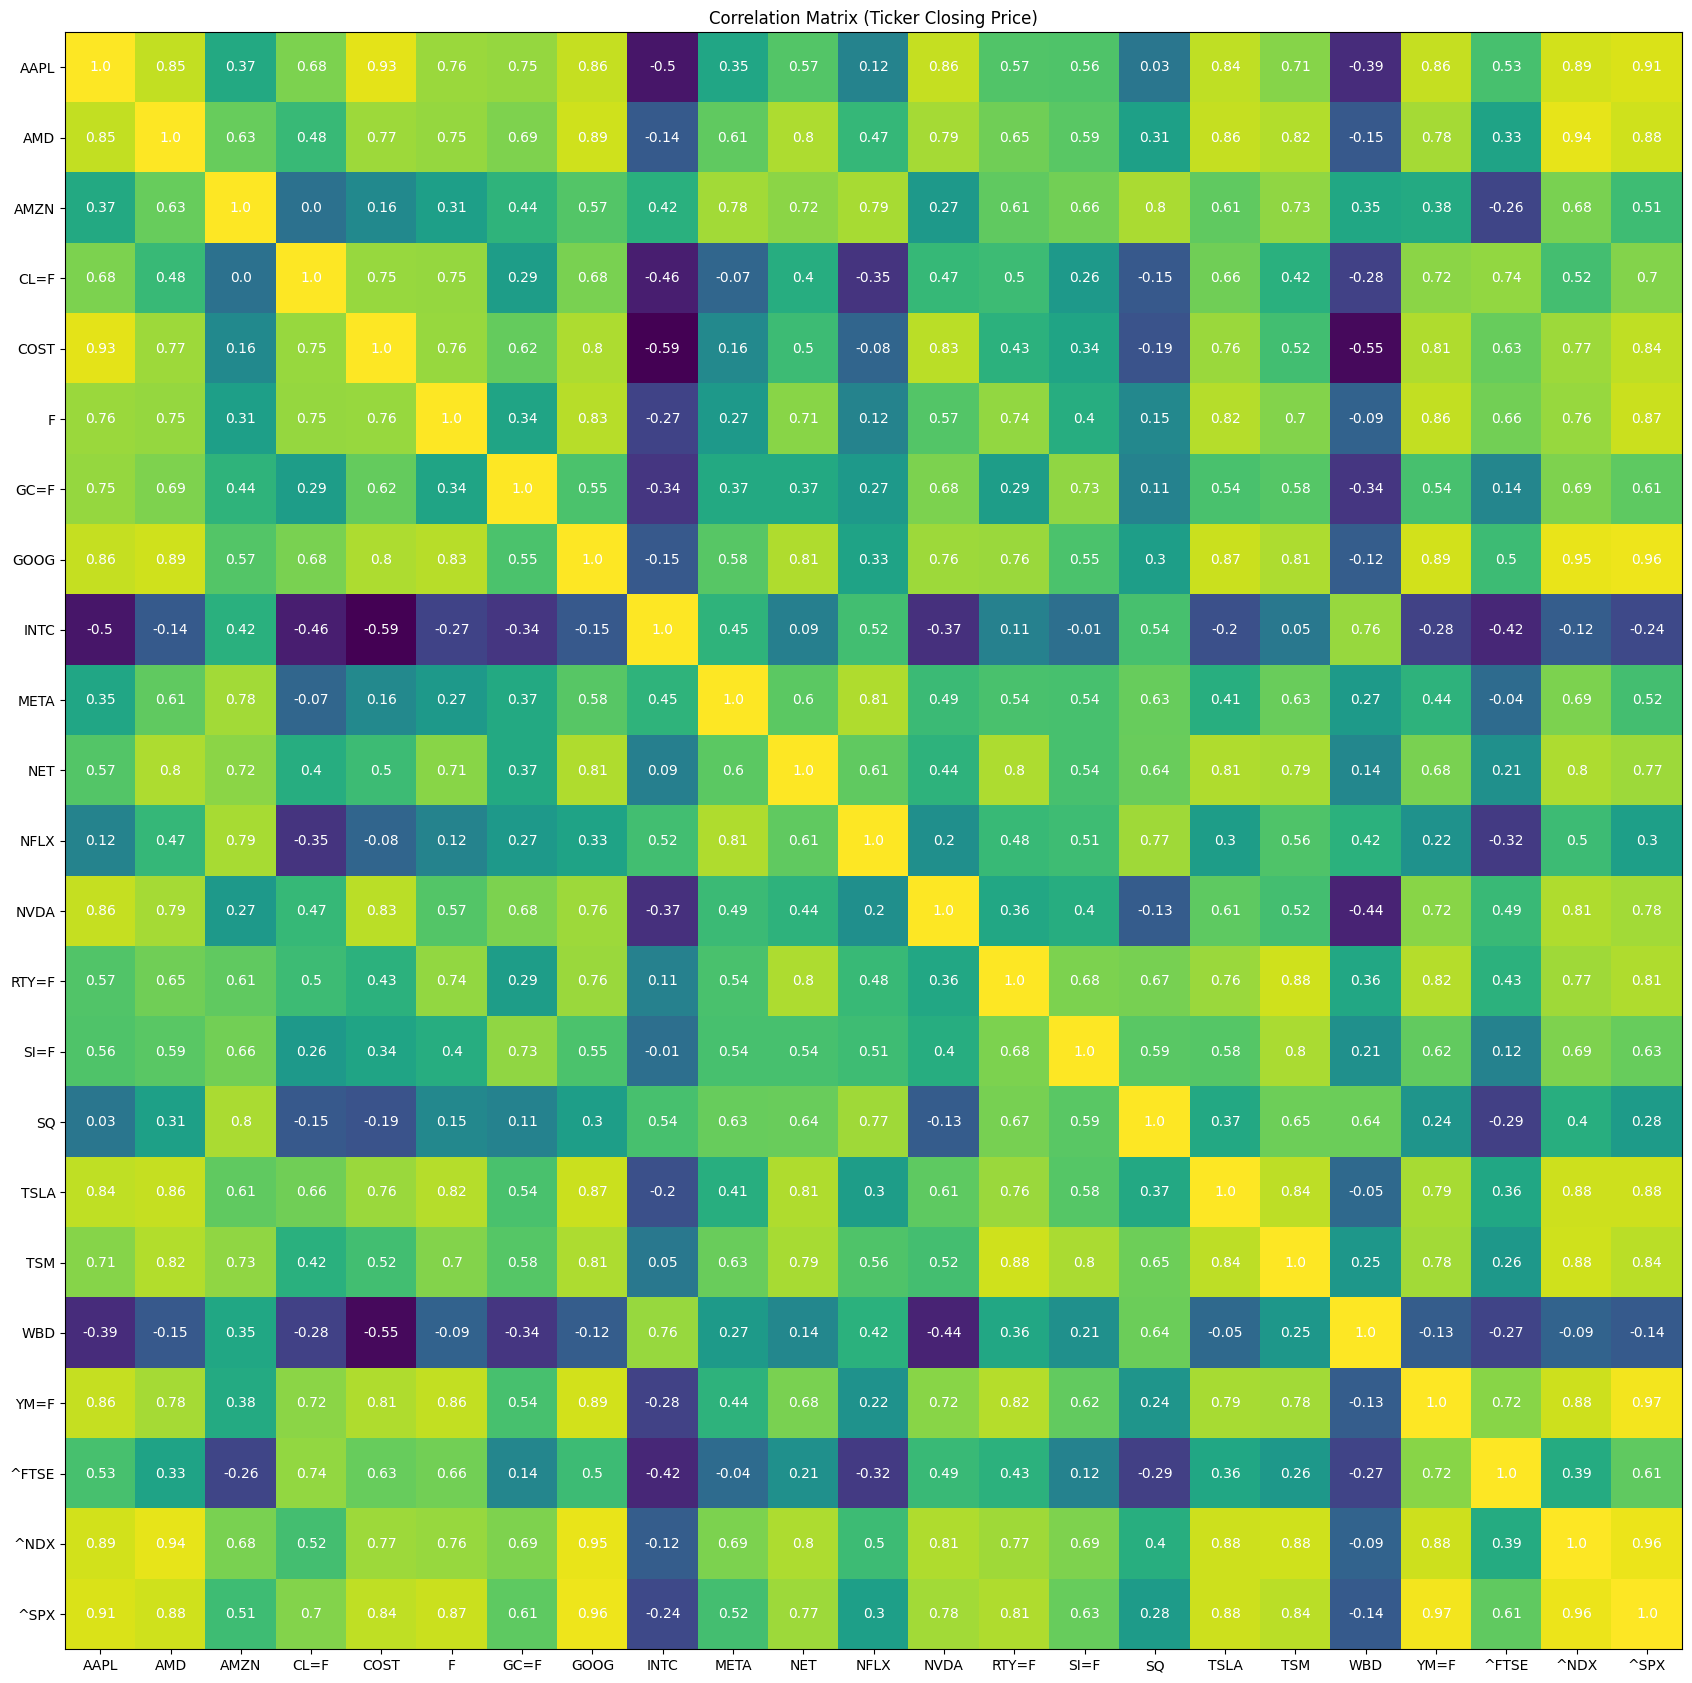

In [12]:
plot_corr_matrix(corr2)

In [13]:
filtered2 = corr2.filter(
    pl.Expr.and_(
        pl.col("ticker_x").eq(TARGET), 
        pl.col("correlation").ge(THRESHOLD)
    )
)
filtered2

ticker_x,ticker_y,correlation
str,str,f64
"""AAPL""","""AAPL""",1.0
"""AAPL""","""AMD""",0.854756
"""AAPL""","""COST""",0.933928
"""AAPL""","""GOOG""",0.86063
"""AAPL""","""NVDA""",0.858724
"""AAPL""","""TSLA""",0.844554
"""AAPL""","""YM=F""",0.858912
"""AAPL""","""^NDX""",0.892062
"""AAPL""","""^SPX""",0.912054


Since the analysis above are done separated for different time periods, we use the query below to find the tickers that passed our criterias in either of the time periods and these tickers are those that we should use in our model.

In [16]:
selected = filtered1.join(filtered2, on=["ticker_x", "ticker_y"], how="outer_coalesce")["ticker_y"]
selected.to_list()

['AAPL',
 'AMD',
 'AMZN',
 'COST',
 'GOOG',
 'INTC',
 'META',
 'NFLX',
 'NVDA',
 'TSM',
 'YM=F',
 '^NDX',
 '^SPX',
 'TSLA']

To find the eliminated tickers, we simply just compare the selected ones with our original list.

In [17]:
eliminated = []
for ticker in TICKERS:
    if ticker not in selected.to_list():
        eliminated.append(ticker)

eliminated

['RTY=F', '^FTSE', 'NET', 'GC=F', 'SI=F', 'CL=F', 'SQ', 'F', 'WBD']

In [18]:
print(f"Out of {len(TICKERS)} tickers, {len(selected.to_list())} is selected and {len(eliminated)} is eliminated.")

Out of 23 tickers, 14 is selected and 9 is eliminated.
